# Critical Introduction to Natural Language Processing

Using only the raw text, we'll derive and explore the semantic properties of its words.

## Imports

Python code in one module gains access to the code in another module by the process of importing it. The import statement is the most common way of invoking the import machinery, but it is not the only way.

In [1]:
from __future__ import absolute_import, division, print_function

First we import common system-tools etc. here that are not directly connected to NLP


In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import sklearn.manifold
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


You will probably run into an "ModuleNorFoundError" here. THis means that the needed module is not installed on your system.
You can do that in the anaconda command prompt:
for example: <b>"conda install -c anaconda nltk"</b> or <b>"conda install -c anaconda gensim"</b> and <b>"conda install -c conda-forge glob2"</b> <br> for detailed information refer to https://docs.anaconda.com/anaconda/user-guide/tasks/install-packages/ <br>


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("txtdata\*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['txtdata\\truth-and-method-gadamer-2004.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'txtdata\truth-and-method-gadamer-2004.txt'...
Corpus is now 1618721 characters long



**Build your vocabulary (word tokenization)**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation.

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The hermeneutic phenomenon is
basically not a problem of method at all.
['The', 'hermeneutic', 'phenomenon', 'is', 'basically', 'not', 'a', 'problem', 'of', 'method', 'at', 'all']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 260,890 tokens


## Train Word2Vec

Word2vec is a method of computing vector representations of words introduced by a team of researchers at Google led by Tomas Mikolov. Google hosts an open-source version of Word2vec released under an Apache 2.0 license. In 2014, Mikolov left Google for Facebook, and in May 2015, Google was granted a patent for the method, which does not abrogate the Apache license under which it has been released. <br>

<b>Foreign Languages</b> <br>

While words in all languages may be converted into vectors with Word2vec, and those vectors learned with deep-learning frameworks, NLP preprocessing can be very language specific, and requires tools beyond our libraries. The Stanford Natural Language Processing Group has a number of Java-based tools for tokenization, part-of-speech tagging and named-entity recognition for languages such as Mandarin Chinese, Arabic, French, German and Spanish. For Japanese, NLP tools like Kuromoji are useful. Other foreign-language resources, including text corpora, are available here.
http://www-nlp.stanford.edu/links/statnlp.html

In [16]:
size = 160
window = 10 
min_count = 5
workers = multiprocessing.cpu_count()
sg = 1
seed = 1
sample = 1e-3
iter = 5

<b>size (int, optional)</b> – Dimensionality of the word vectors.

<b>window (int, optional)</b> – Maximum distance between the current and predicted word within a sentence.

<b>min_count (int, optional)</b> – Ignores all words with total frequency lower than this.

<b>workers (int, optional)</b> – Use these many worker threads to train the model (=faster training with multicore machines).

<b>sg ({0, 1}, optional)</b> – Training algorithm: 1 for skip-gram; otherwise CBOW.

<b>seed (int, optional)</b> – Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). Note that for a fully deterministically-reproducible run, you must also limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. (In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization).

<b>sample (float, optional)</b> – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

<b>iter (int, optional)</b> – Number of iterations (epochs) over the corpus.

https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
word2vec = w2v.Word2Vec(
    size = size,
    window = window,
    min_count = min_count,
    workers = workers,
    sg = sg,
    seed = seed,
    sample = sample,
    iter = iter
)

In [18]:
word2vec.build_vocab(sentences)

2019-12-10 14:23:58,425 : INFO : collecting all words and their counts
2019-12-10 14:23:58,428 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-10 14:23:58,554 : INFO : PROGRESS: at sentence #10000, processed 223470 words, keeping 11480 word types
2019-12-10 14:23:58,596 : INFO : collected 12895 word types from a corpus of 260890 raw words and 11459 sentences
2019-12-10 14:23:58,601 : INFO : Loading a fresh vocabulary
2019-12-10 14:23:58,660 : INFO : min_count=5 retains 3740 unique words (29% of original 12895, drops 9155)
2019-12-10 14:23:58,665 : INFO : min_count=5 leaves 245816 word corpus (94% of original 260890, drops 15074)
2019-12-10 14:23:58,737 : INFO : deleting the raw counts dictionary of 12895 items
2019-12-10 14:23:58,739 : INFO : sample=0.001 downsamples 46 most-common words
2019-12-10 14:23:58,741 : INFO : downsampling leaves estimated 174873 word corpus (71.1% of prior 245816)
2019-12-10 14:23:58,760 : INFO : estimated required memory f

In [19]:
print("Word2Vec vocabulary length:", len(word2vec.wv.vocab))

Word2Vec vocabulary length: 3740


**Start training, this might take a minute or two...**

In [20]:
word2vec.train(sentences, total_words=token_count, epochs = 10 )

2019-12-10 14:25:39,689 : INFO : training model with 2 workers on 3740 vocabulary and 160 features, using sg=1 hs=0 sample=0.001 negative=5 window=10
2019-12-10 14:25:41,044 : INFO : EPOCH 1 - PROGRESS: at 34.43% words, 52362 words/s, in_qsize 3, out_qsize 0
2019-12-10 14:25:42,128 : INFO : EPOCH 1 - PROGRESS: at 80.36% words, 63216 words/s, in_qsize 3, out_qsize 0
2019-12-10 14:25:42,514 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-10 14:25:42,550 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-10 14:25:42,551 : INFO : EPOCH - 1 : training on 260890 raw words (175017 effective words) took 2.6s, 66051 effective words/s
2019-12-10 14:25:43,616 : INFO : EPOCH 2 - PROGRESS: at 42.09% words, 69701 words/s, in_qsize 3, out_qsize 0
2019-12-10 14:25:44,698 : INFO : EPOCH 2 - PROGRESS: at 88.01% words, 72106 words/s, in_qsize 3, out_qsize 0
2019-12-10 14:25:44,904 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12

(1749194, 2608900)

**Save to file, can be useful later**

In [21]:
word2vec.save("word2vecGadamer.w2v")

2019-12-10 14:28:29,320 : INFO : saving Word2Vec object under word2vecGadamer.w2v, separately None
2019-12-10 14:28:29,322 : INFO : not storing attribute vectors_norm
2019-12-10 14:28:29,326 : INFO : not storing attribute cum_table
C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-10 14:28:29,513 : INFO : saved word2vecGadamer.w2v


## Explore the trained model.

In [22]:
word2vec = w2v.Word2Vec.load("word2vecGadamer.w2v")

2019-12-10 14:36:29,496 : INFO : loading Word2Vec object from word2vecGadamer.w2v
C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-10 14:36:29,799 : INFO : loading wv recursively from word2vecGadamer.w2v.wv.* with mmap=None
2019-12-10 14:36:29,801 : INFO : setting ignored attribute vectors_norm to None
2019-12-10 14:36:29,802 : INFO : loading vocabulary recursively from word2vecGadamer.w2v.vocabulary.* with mmap=None
2019-12-10 14:36:29,804 : INFO : loading trainables recursively from word2vecGadamer.w2v.trainables.* with mmap=None
2019-12-10 14:36:29,806 : INFO : setting ignored attribute cum_table to None
2019-12-10 14:36:29,807 : INFO : loaded word2vecGadamer.w2v


In [23]:
print(word2vec.wv.most_similar('hermeneutics', topn=5))

2019-12-10 14:36:59,143 : INFO : precomputing L2-norms of word weight vectors


[('theology', 0.676480770111084), ('theological', 0.6612817645072937), ('philological', 0.6136495471000671), ('positivism', 0.5938568711280823), ('Protestant', 0.5913993120193481)]


In [24]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [25]:
all_word_vectors_matrix = word2vec.wv.vectors

In [26]:
all_word_vectors_matrix_2d = tsne_model_en_2d.fit_transform(all_word_vectors_matrix)

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
            for word in word2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,Introduction,80.600929,5.985029
1,These,14.673154,-1.529460
2,studies,45.849213,35.693295
3,are,-40.333424,-14.221912
4,concerned,-21.195379,-47.314026
5,with,-42.802757,-8.228091
6,the,-5.381125,-29.452608
7,problem,24.402020,-22.375614
8,of,-21.538010,-19.374031
9,hermeneutics,43.990391,32.694294


In [29]:
sns.set_context("poster")

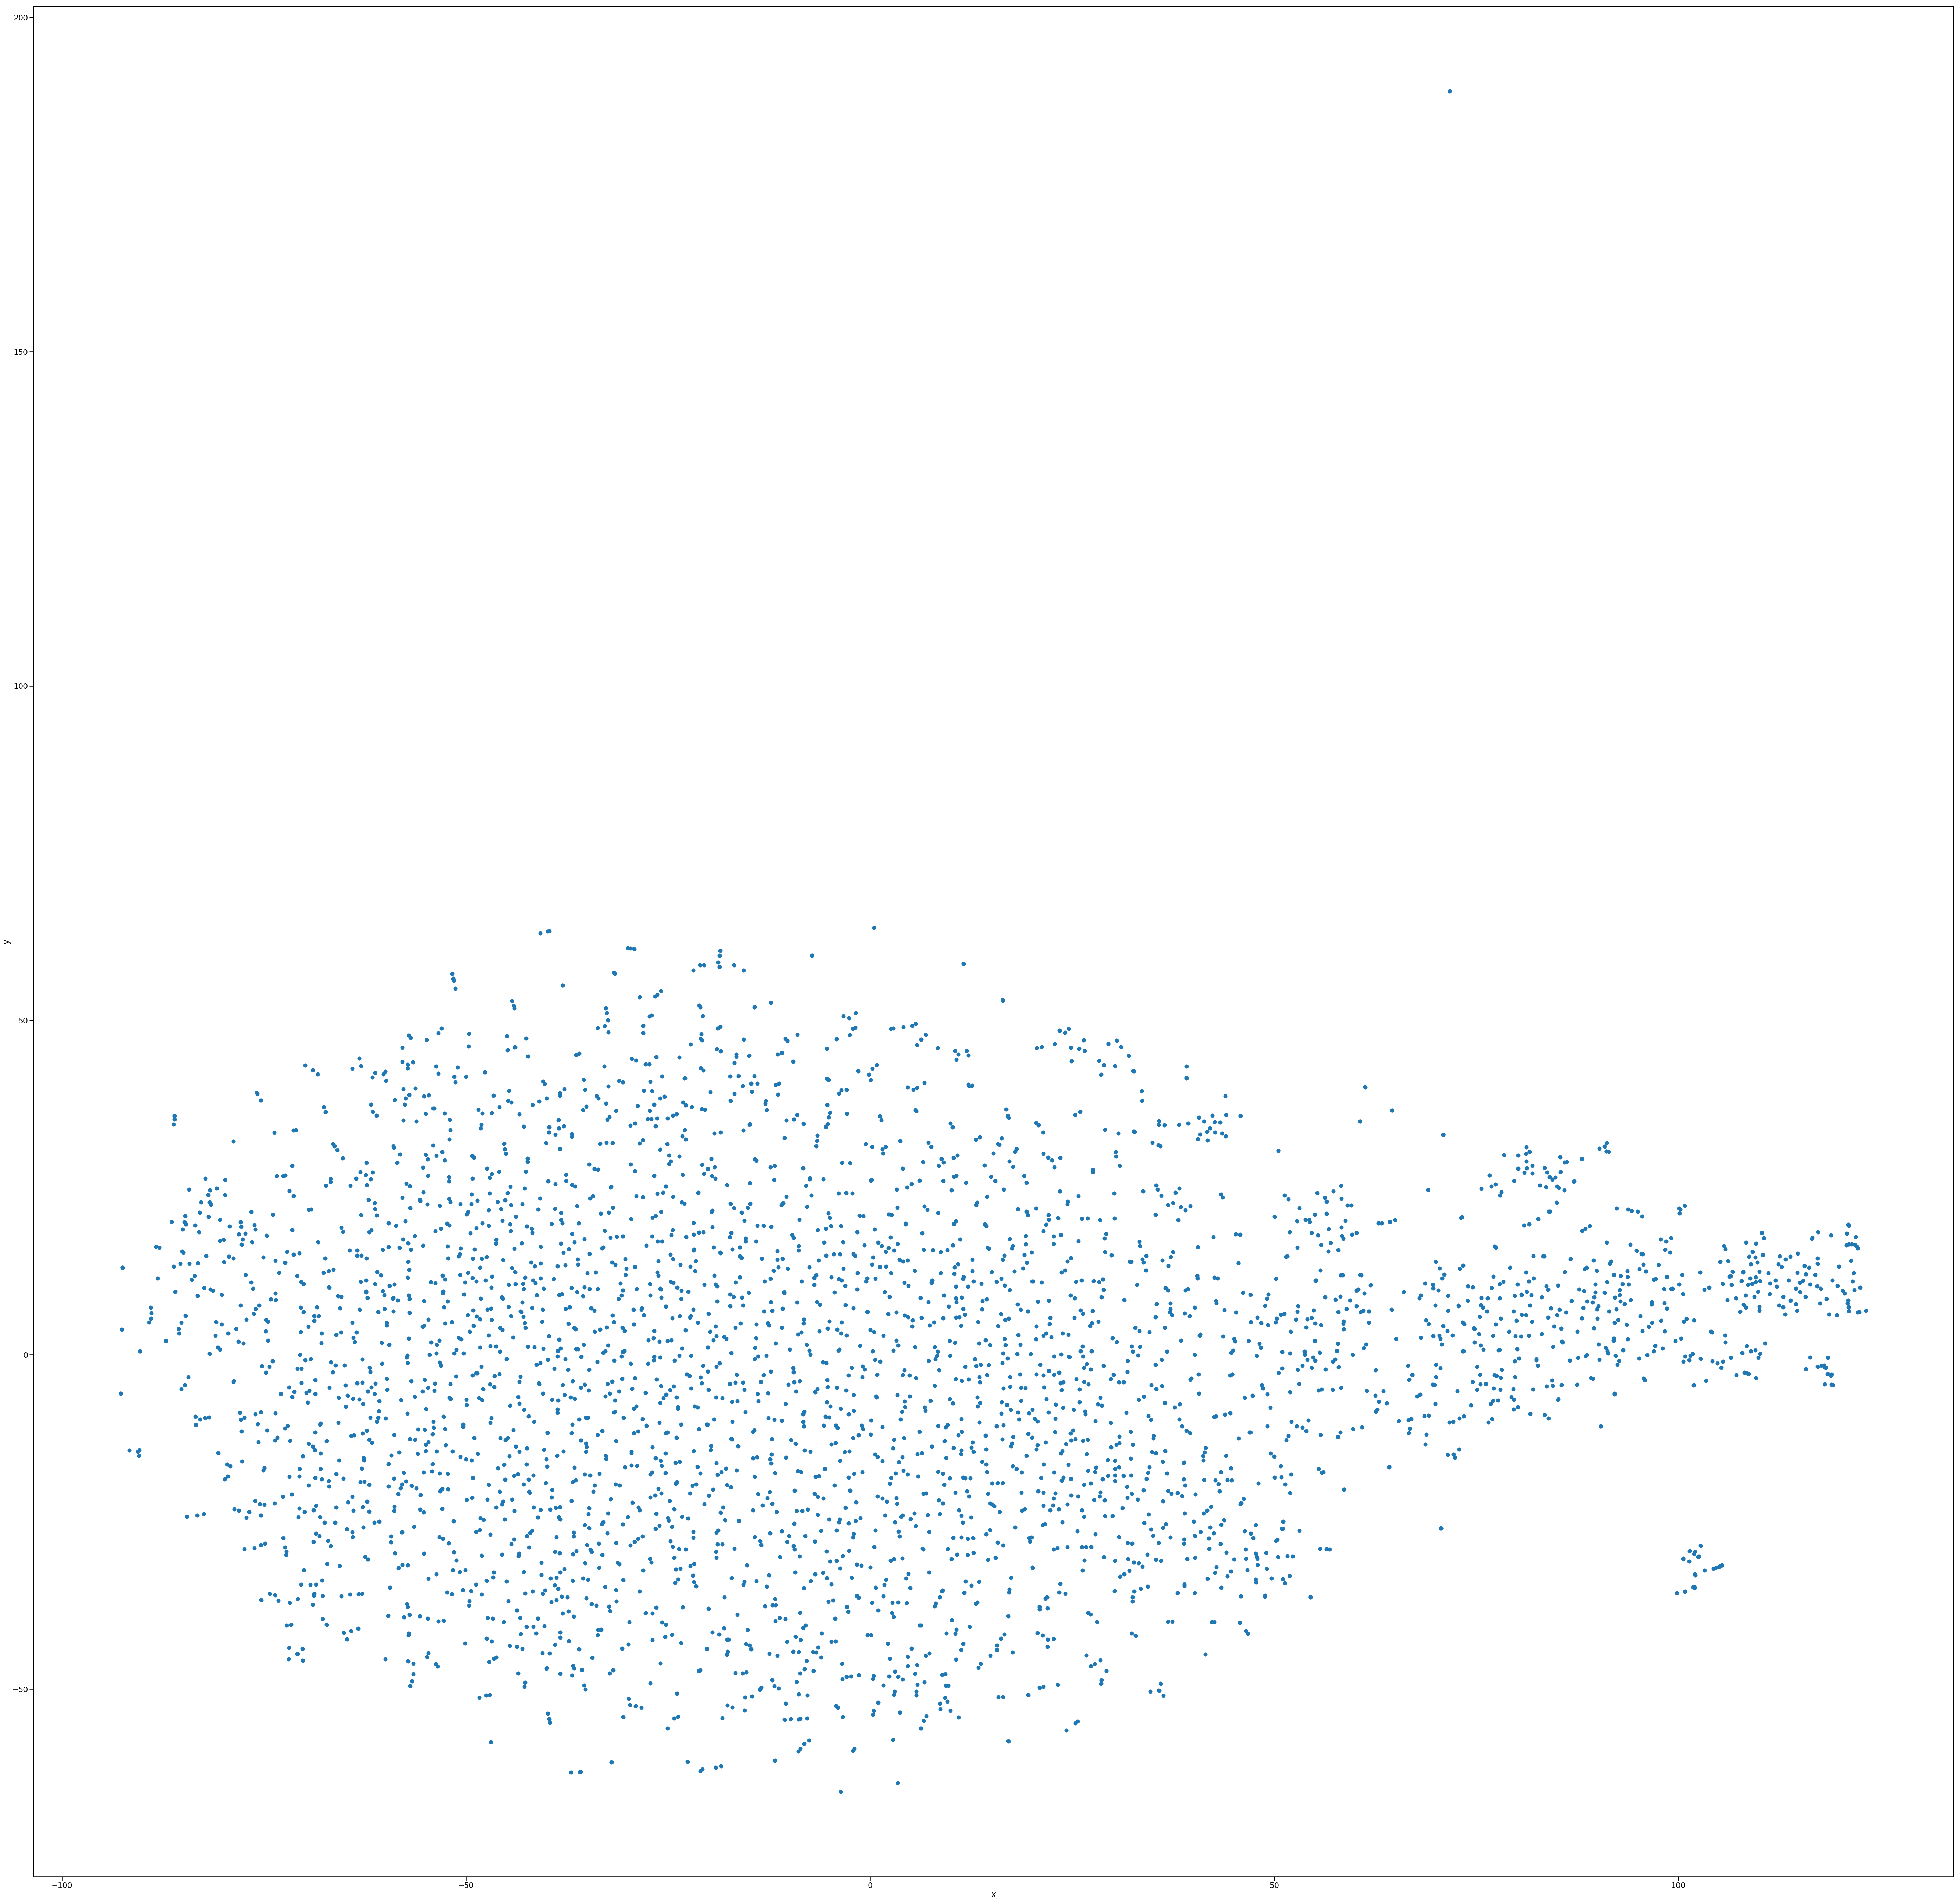

In [30]:
points.plot.scatter("x", "y", s=100, figsize=(100, 100))

In [31]:
word2vec.wv.most_similar("language")

[('foreign', 0.5994593501091003),
 ('linguistic', 0.5949352383613586),
 ('medium', 0.591860294342041),
 ('languages', 0.5632306337356567),
 ('translating', 0.5620236992835999),
 ('spoken', 0.5603138208389282),
 ('enters', 0.5585079789161682),
 ('communication', 0.5484299659729004),
 ('words', 0.5413626432418823),
 ('usage', 0.5306564569473267)]

Linear relationships between word pairs

In [32]:
word2vec.wv.most_similar(positive=['language'], negative=['truth'])

[('linguistic', 0.3451696038246155),
 ('foreign', 0.3344371020793915),
 ('languages', 0.292691707611084),
 ('formation', 0.27389633655548096),
 ('word', 0.269162654876709),
 ('words', 0.26857730746269226),
 ('usage', 0.2493215948343277),
 ('Latin', 0.24914583563804626),
 ('Humboldt', 0.2144480049610138),
 ('translation', 0.20564880967140198)]

In [33]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = word2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [34]:
nearest_similarity_cosmul("language", "power", "state")

language is related to power, as foreign is related to state


'foreign'